In [14]:
from google.colab import drive
drive.mount('/content/driver')

Drive already mounted at /content/driver; to attempt to forcibly remount, call drive.mount("/content/driver", force_remount=True).


In [15]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import yfinance as yf
import pandas_datareader.data as pdr
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

In [17]:
#Load data  
yf.pdr_override()

start_date = '01-01-2014'
end_date = '01-01-2021'

company = 'NFLX'

start = datetime.strptime(start_date, '%d-%m-%Y')
end = datetime.strptime(end_date, '%d-%m-%Y')
df = pdr.get_data_yahoo(company, data_source='yahoo', start=start, end=end)
df.round(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,52.40,52.51,51.54,51.83,51.83,12325600
2014-01-03,52.00,52.50,51.84,51.87,51.87,10817100
2014-01-06,51.89,52.04,50.48,51.37,51.37,15501500
2014-01-07,49.68,49.70,48.15,48.50,48.50,36167600
2014-01-08,48.10,49.43,48.07,48.71,48.71,20001100
...,...,...,...,...,...,...
2020-12-24,515.12,519.35,512.21,513.97,513.97,1144000
2020-12-28,516.43,523.66,507.13,519.12,519.12,2891900
2020-12-29,519.90,536.55,515.48,530.87,530.87,4022400


In [18]:
#Get number of trading days
df.shape

(1763, 6)

In [19]:
#Create a new dataframe with only the 'Close'
data = df.filter(['Close'])
data

,Close
Date,
2014-01-02,51.831429
2014-01-03,51.871429
2014-01-06,51.367142
2014-01-07,48.500000
2014-01-08,48.712856
...,...
2020-12-24,513.969971
2020-12-28,519.119995
2020-12-29,530.869995


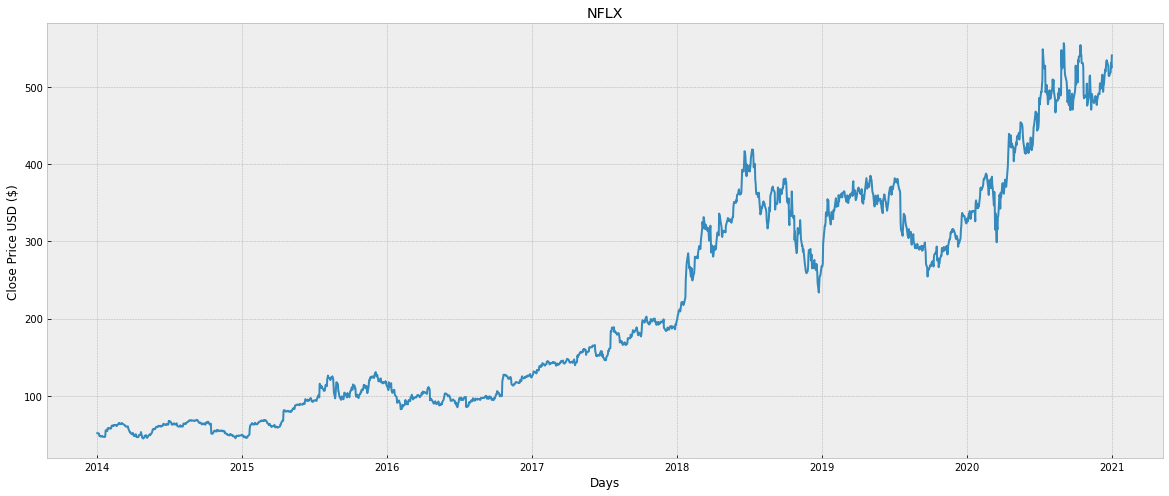

In [20]:
#Visualize the close price data
plt.figure(figsize=(20,8))
plt.title(company)
plt.xlabel('Days')
plt.ylabel('Close Price USD ($)')
plt.plot(data['Close'])
plt.show()

### Bổ trợ kiến thức : ✅ Data Normalization 
- y là biến sau normalize, x là biến trước normalize.  
Phương pháp này yêu cầu chúng ta cần xác định được giá trị lớn nhất (max) và giá trị nhỏ nhất (min) của dữ liệu. 
Công thức:
> y = (x - min) / (max - min)

Các bước thực hiện:
 Để normalize thì dữ liệu huấn 

*  Fit biến scaler sử dụng tập dữ liệu huấn luyện.
*   Để normalize thì dữ liệu huấn luyện cần phải được xác định giá trị max và min. Để thực hiện chúng ta gọi hàm fit().
Tiến hành scale dữ liệu bằng cách gọi hàm transform().
* Áp dụng lại bộ scaler để sử dụng cho việc dự đoán về sau.

Ví dụ phía dưới đây là normalization dữ liệu cột Close.



In [27]:
#Prepare data
# Bộ scaler MinMaxScaler sẽ đưa các biến về miền giá trị [0, 1], sử dụng tham số feature_range để đưa vào giá trị min và max nếu bạn muốn.
scaler = MinMaxScaler(feature_range=(0,1))

# fit và transform đồng thời ,  quay lại miền giá trị cũ: goi ham inverse_transform
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
len(scaled_data)

[[0.013572  ]
 [0.01365017]
 [0.01266459]
 ...
 [0.94981071]
 [0.93753707]
 [0.96908119]]


1763

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [22]:
#Create x_train, y_train
prediction_days = 60
x_train = []
y_train = []
for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
#Reshape x_train
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1703, 60, 1)

In [23]:
#Build the LSTM Model
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
model.fit(x_train, y_train, epochs = 100, batch_size = 32)
model.save('/content/driver/My Drive/Colab Notebooks/model/stock03.h5')

Epoch 1/100
54/54 [==============================] - 6s 16ms/step - loss: 0.0194
Epoch 2/100
54/54 [==============================] - 1s 15ms/step - loss: 0.0041
Epoch 3/100
54/54 [==============================] - 1s 15ms/step - loss: 0.0036
Epoch 4/100
54/54 [==============================] - 1s 15ms/step - loss: 0.0033
Epoch 5/100
54/54 [==============================] - 1s 14ms/step - loss: 0.0031
Epoch 6/100
54/54 [==============================] - 1s 18ms/step - loss: 0.0029
Epoch 7/100
54/54 [==============================] - 1s 24ms/step - loss: 0.0032
Epoch 8/100
54/54 [==============================] - 1s 23ms/step - loss: 0.0030
Epoch 9/100
54/54 [==============================] - 1s 26ms/step - loss: 0.0029
Epoch 10/100
54/54 [==============================] - 2s 29ms/step - loss: 0.0028
Epoch 11/100
54/54 [==============================] - 1s 22ms/step - loss: 0.0029
Epoch 12/100
54/54 [==============================] - 1s 22ms/step - loss: 0.0026
Epoch 13/100
54/54 [=====

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-01-04  539.000000  540.799988  515.090027  522.859985  522.859985   
2021-01-05  521.549988  526.780029  515.890015  520.799988  520.799988   
2021-01-06  511.970001  513.099976  499.500000  500.489990  500.489990   
2021-01-07  508.279999  516.440002  506.420013  508.890015  508.890015   
2021-01-08  511.309998  513.239990  504.510010  510.399994  510.399994   
...                ...         ...         ...         ...         ...   
2021-07-21  526.130005  530.989990  505.609985  513.630005  513.630005   
2021-07-22  510.209991  513.679993  507.000000  511.769989  511.769989   
2021-07-23  512.159973  517.409973  504.660004  515.409973  515.409973   
2021-07-26  514.380005  521.130005  509.010010  516.489990  516.489990   
2021-07-27  518.080017  521.950012  512.049

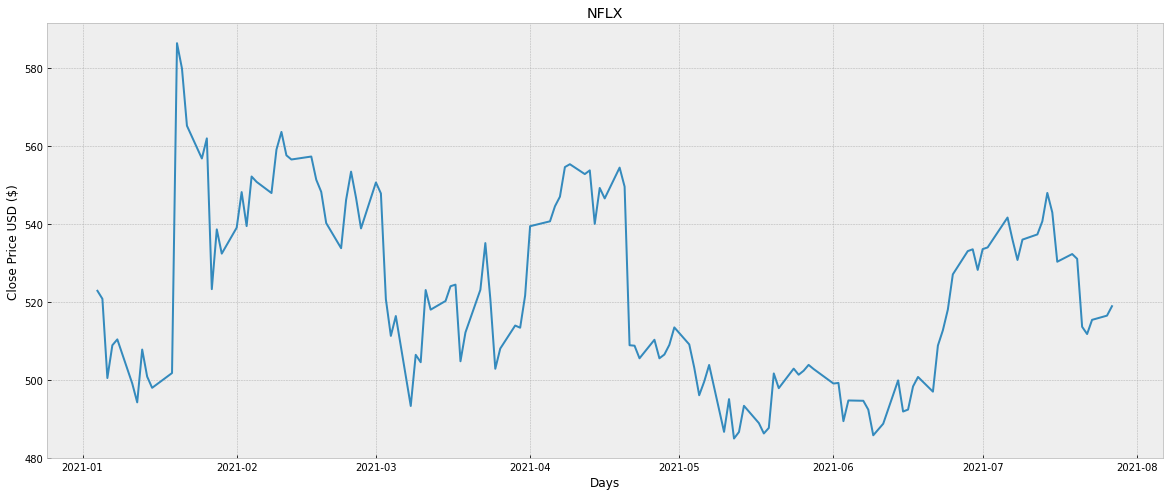

In [24]:
#Load the test data
yf.pdr_override()

start_date = '01-01-2021'
end_date = '28-07-2021'

start = datetime.strptime(start_date, '%d-%m-%Y')
end = datetime.strptime(end_date, '%d-%m-%Y')
test_data = pdr.get_data_yahoo(company, data_source='yahoo', start=start, end=end)

actual_prices = test_data['Close'].values
total_dataset = pd.concat((data['Close'],test_data['Close']), axis = 0)
inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
print(test_data)
#Visualize the test data
plt.figure(figsize=(20,8))
plt.title(company)
plt.xlabel('Days')
plt.ylabel('Close Price USD ($)')
plt.plot(test_data['Close'])
plt.show()

In [28]:
#Prediction on test data
x_test = []
for x in range(prediction_days, len(inputs)):
  x_test.append(inputs[x-prediction_days:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

model = keras.models.load_model('/content/driver/My Drive/Colab Notebooks/model/stock03.h5')
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

5/5 [==============================] - 2s 14ms/step


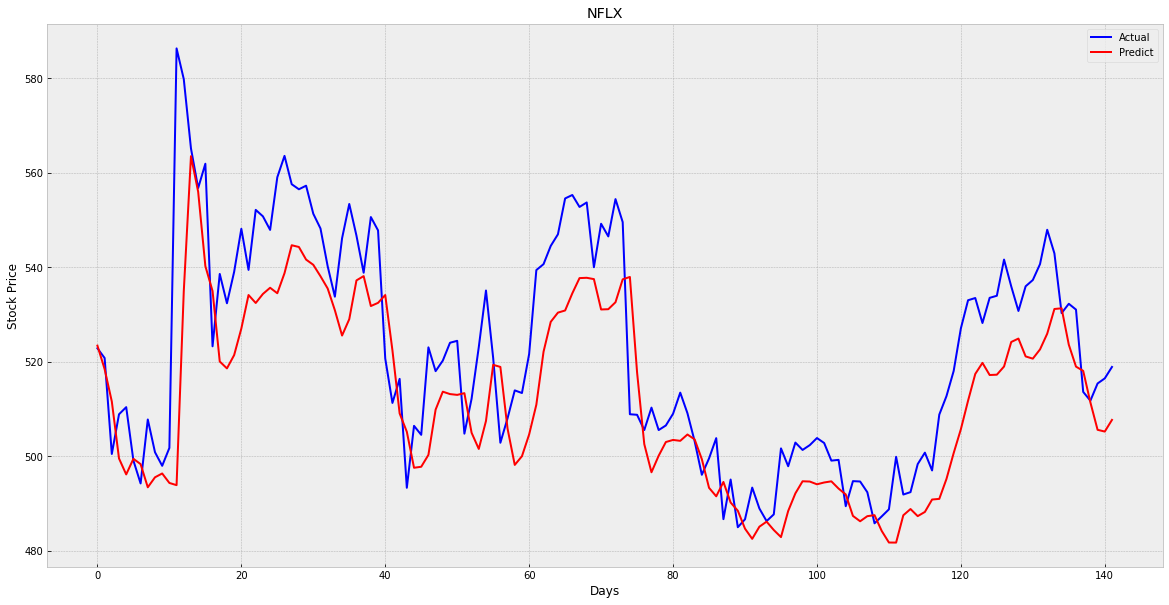

In [29]:
#visualize the data
plt.figure(figsize=(20,10))
plt.title(company)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.plot(actual_prices, color="blue")
plt.plot(predicted_prices, color="red")
plt.legend(['Actual', 'Predict'])
plt.show()

In [30]:
#Predict the next day
real_data = [inputs[len(inputs) + 1 - prediction_days:len(inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
prediction = model.predict(real_data)
# biến aa là biến phần trăn giảm/ tăng của giá mã chứng khoán này 
aa=float((prediction-inputs[-1])*100)

prediction = scaler.inverse_transform(prediction)
print(f"Prediction of the next day: {prediction}")
print(f"Predict: {aa:.2f}%")

1/1 [==============================] - 1s 1s/step
Prediction of the next day: [[510.53192]]
Predict: -1.64%
